In [6]:
import os 
import sys 
sys.path.append('./src')
import pandas as pd 
import re
from occm import *
from cvrg import *  
from ncbi import download
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import matplotlib.cm
import matplotlib.colors 
from files import FastaFile
import pickle
import torch
from sklearn.decomposition import PCA

DATA_DIR = os.path.abspath('./data')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
with open('./data/contigs_coverage_95_gLM2_650M.pkl', 'rb') as f:
    emb_dict = pickle.load(f)

embs, ids = [], []
for id_, emb in emb_dict.items():
    embs.append(torch.unsqueeze(emb, 0))
    ids.append(id_)

embs = torch.cat(embs)
print('Shape of concatenated embeddings:', embs.shape)

pca = PCA(n_components=2)
components = pca.fit_transform(embs.to(torch.float32))

Shape of concatenated embeddings: torch.Size([252783, 1280])


In [39]:
# Want to get the genome IDs from the contig IDs. Remove the last underscore from the ID. 
genome_ids = ['_'.join(id_.split('_')[:-1]) for id_ in ids]
# Also need to remove the path stuff. 
genome_ids = [os.path.basename(id_) for id_ in genome_ids]
genome_ids = np.array(genome_ids).ravel()

# I think only look at a few of the genomes for now, as 196 is a bit too many to visualize. 
subset = np.random.choice(np.unique(genome_ids), 5, repace=False)
components_subset = components[np.isin(genome_ids, subset), :]
genome_ids_subset = genome_ids[np.isin(genome_ids, subset)]

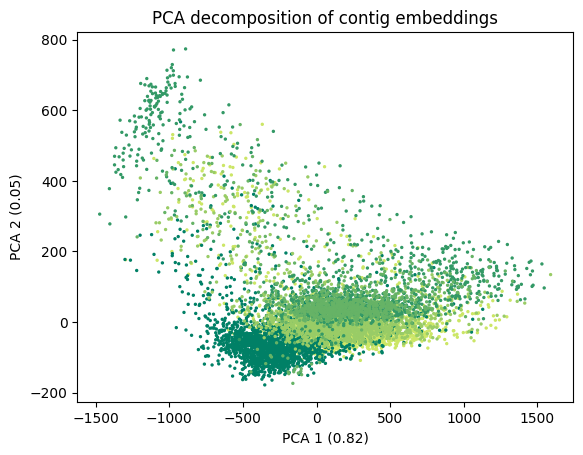

In [42]:
fig, ax = plt.subplots()

n_genomes = len(np.unique(genome_ids_subset))
norm = matplotlib.colors.Normalize(vmin=0, vmax=n_genomes)

cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap='summer')
colors = [cmap.to_rgba(np.where(np.unique(genome_ids_subset) == id_)[0]) for id_ in genome_ids_subset]

ax.scatter(components_subset[:, 0], components_subset[:, 1], s=2, c=colors)
var = pca.explained_variance_ratio_

ax.set_xlabel(f'PCA 1 ({np.round(var[0], 2)})')
ax.set_ylabel(f'PCA 2 ({np.round(var[1], 2)})')
ax.set_title('PCA decomposition of contig embeddings')
plt.show()


In [71]:
genome_ids = pd.read_csv('./data/genomes.csv', usecols=['accession']).values.ravel()
genome_ids = [genome_id.replace('GB_', '').replace('RS_', '') for genome_id in genome_ids]
download(genome_ids, path='./data/genomes/')

download_genomes:   0%|          | 0/196 [00:00<?, ?it/s]

download_genomes: 100%|██████████| 196/196 [11:51<00:00,  3.63s/it]


Total genomes: 196


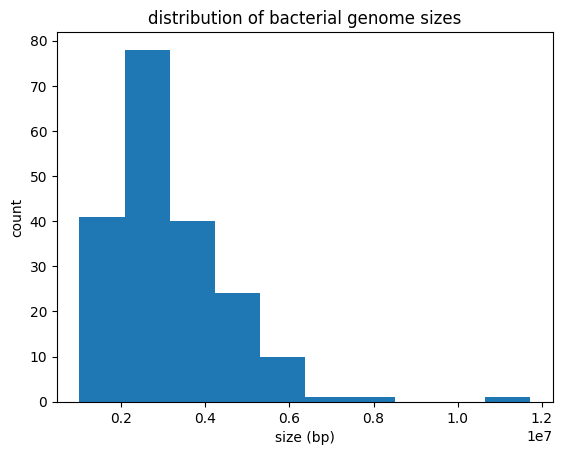

In [3]:
# Take a look at the length distributions of the genomes obtained from NCBI. 
genomes_df = pd.read_csv(os.path.join(DATA_DIR, 'genomes.csv'))
print('Total genomes:', len(genomes_df))
genome_sizes = genomes_df.genome_size.values 

fig, ax = plt.subplots()
ax.hist(genome_sizes)
ax.set_title('distribution of bacterial genome sizes')
ax.set_ylabel('count')
ax.set_xlabel('size (bp)')
plt.show()

Mean genome size: 3718969.3


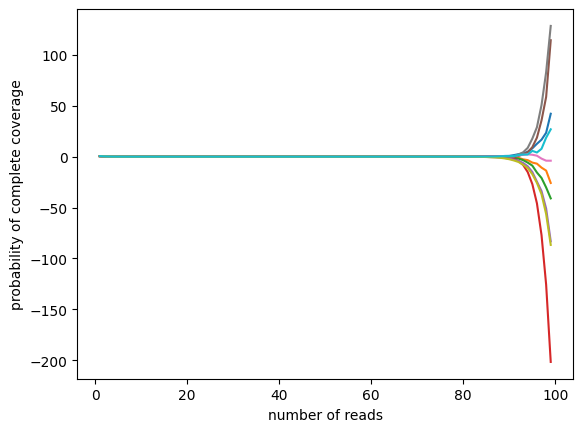

In [40]:
total_reads = 25000000 # Woody said this is a reasonable read depth. 
read_length = 300

# Could be problematic to be tuning abundances, because then it's going to be a 196-variable equation. 
# I also think that because I can't just set abundance to zero? But maybe?
# Actually, I think what I might do is set abundance to 1, and let the read count be alpha * total_reads. 

genomes_df_subset = genomes_df.sample(10) # Grab a few of the genomes for now. 
fig, ax = plt.subplots(1)

print('Mean genome size:', genomes_df_subset.genome_size.mean())

for row in genomes_df_subset.itertuples():
    x_vals = np.arange(1, 100)
    # Maybe want to tune total reads, and use this to inform abundance?
    y_vals = [coverage_wendl_2013(alpha=0.12, R=int(x), L=read_length, gamma=int(row.genome_size)) for x in x_vals]
    ax.plot(x_vals, y_vals)

ax.set_xlabel('number of reads')
ax.set_ylabel('probability of complete coverage')
plt.show()
# Want to have a plot with abundance on the x-axis and probability of complete coverage on the y-axis. 

In [53]:
# Trying this with values from the paper...
R = 0.12 * 4.5e6
# coverage_wendl_2013(alpha=0.12, R=4.5e6, gamma=2936981, L=100)
# coverage_wendl_2013(alpha=1, R=540000.0, gamma=2936981, L=100)
coverage_wendl_2013(alpha=1, R=1000, gamma=2936981, L=100)

coverage_wendl_2013: Current value of summation is -3.554651436523099e+39.:   2%|▏         | 19/1001 [00:00<00:01, 941.49it/s] 

coverage_wendl_2013: Current value of summation is -9.618379061650967e+278.: 100%|██████████| 1001/1001 [00:01<00:00, 609.57it/s] 


Decimal('-9.618379061650965133205836854E+278')

In [4]:
# Download the latest GTDB bacteria metadata from the FTP site https://data.gtdb.ecogenomic.org/releases/latest/
gtdb_metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'bac120_metadata_r220.tsv'), sep='\t')
print(len(gtdb_metadata_df), 'total genome entries in GTDB.')
# Filter for complete genomes. 
gtdb_metadata_df = gtdb_metadata_df[gtdb_metadata_df.ncbi_genome_representation == 'full']
print(len(gtdb_metadata_df), 'total complete genome entries in GTDB.')

584382 total genome entries in GTDB.
584319 total complete genome entries in GTDB.


In [33]:
# for col in gtdb_metadata_df.columns:
#     print(col)

In [30]:
def get_taxonomy(gtdb_metadata_df:pd.DataFrame, level:str='p'):
    '''Extract the taxonomy from the lineage string in the metadata.'''
    taxonomy = []
    for entry in gtdb_metadata_df.gtdb_taxonomy:
        match = re.search(f'{level}__([^;]+)', entry)
        if match is None:
            taxonomy.append(None)
        else:
            taxonomy.append(match.group(1))
    return taxonomy

In [31]:
gtdb_metadata_df['phylum'] = get_taxonomy(gtdb_metadata_df)
print(len(gtdb_metadata_df.phylum.unique()), 'unique phyla present in the data.')

196 unique phyla present in the data.


In [35]:
# Get the genomes with the highest checkm_completeness from each phylum. 
gtdb_metadata_df = gtdb_metadata_df.sort_values('checkm_completeness', ascending=False).groupby('phylum', as_index=False).first()

In [37]:
gtdb_metadata_df.set_index('accession').to_csv('./data/genomes.csv')

In [50]:
genome = Genome('./data/sequence.fn', read_size=200)
# B = len(genome)
# print(f'Genome contains {B} base pairs.')

Genome.__init__: Loaded 1 sequences from the FASTA file.


In [26]:
def get_max_contig_lengths(genome:Genome, read_depth:int=10000, n_samples:int=500):
    max_contig_lengths = []
    for _ in tqdm(range(n_samples), desc='get_max_contig_lengths'):
        genome.build_graphs(read_depth=read_depth)

        # # What is the average number of next nodes?
        # graph = genome.seqs[0].graph
        # avg_next = np.mean([len(read.next) for read in graph.reads.values()])
        # print('Average number of "next" nodes:', avg_next)

        contigs = genome.get_contigs()
        max_contig_lengths.append(max([len(contig) for contig in contigs]))

    return np.array(sorted(max_contig_lengths))

In [53]:
coverages = []
for i in range(100):
    genome.build_graphs(read_depth=10000)
    contigs = genome.get_contigs()
    coverages.append(genome.seqs[0].get_coverage(contigs))
np.mean(coverages)

np.float64(0.31974004083029056)

Number of bins: 46415
Probability of at least one read occurring in any given bin: 0.3500759873747368


get_max_contig_lengths: 100%|██████████| 500/500 [01:04<00:00,  7.79it/s]

Biggest max contig length: 2800


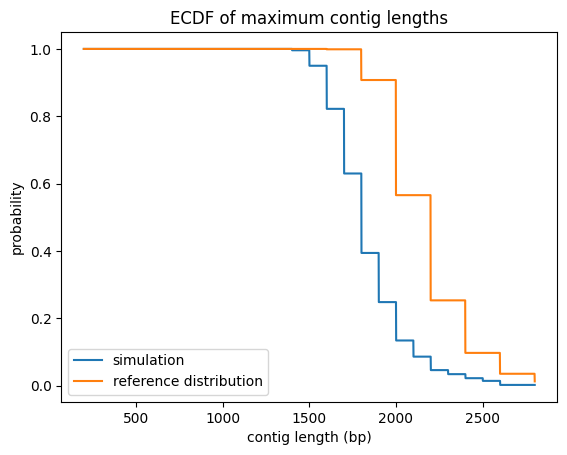

In [45]:
# Plot an ECDF of the maximum contig lengths from different attempts at reading the same genome. 
read_size = 200
read_depth = 20000 
alpha = genome.n_bins()
beta = 1 - (1 - 1 / alpha) ** read_depth # This is the probability of at least one read occurring in every bin. 
print('Number of bins:', alpha)
print('Probability of at least one read occurring in any given bin:', beta) # np.round(beta, 2))

max_contig_lengths = get_max_contig_lengths(genome, read_depth=read_depth, n_samples=500)
print('Biggest max contig length:', max(max_contig_lengths))

fig, ax = plt.subplots()

x_vals, y_vals = [], []
for l in np.arange(read_size, max(max_contig_lengths) + 1):
    x_vals.append(l)
    y_vals.append(np.mean(max_contig_lengths >= l))

y_vals_ref = [pcgtk(r=read_depth, k=x // read_size, b=len(genome), l=read_size) for x in x_vals]

# I think it would be better to put contig length in terms of number of reads, to mirror the paper. 
ax.plot(x_vals, y_vals)
ax.plot(x_vals, y_vals_ref)

ax.legend(['simulation', 'reference distribution'])
ax.set_xlabel('contig length (bp)')
ax.set_ylabel('probability')
ax.set_title('ECDF of maximum contig lengths')
plt.show()


Plotting curves...: 100%|██████████| 196/196 [00:00<00:00, 628.47it/s]


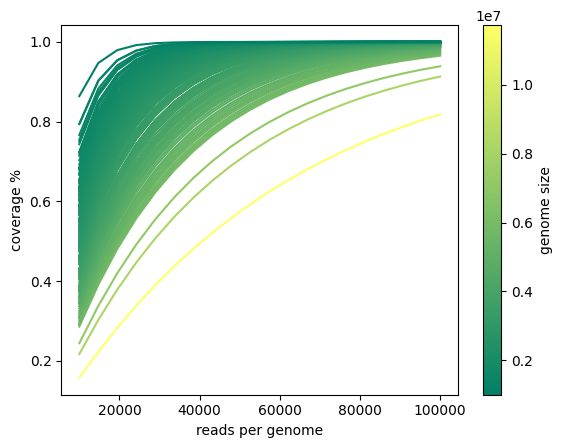

In [2]:
# coverage_lander_waterman_1998(G:int=None, L:int=None, R:int=None, alpha:float=None, T:float=int)

read_size = 200
read_depth = 1e6

fig, ax = plt.subplots()
 
x_vals = np.linspace(0.01, 0.1, 20)
genomes_df = pd.read_csv(os.path.join(DATA_DIR, 'genomes.csv')).sort_values('genome_size', ascending=False)
genome_sizes = genomes_df.genome_size.values.ravel()

norm = matplotlib.colors.Normalize(vmin=min(genome_sizes), vmax=max(genome_sizes))
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap='summer')

for size in tqdm(genome_sizes, desc='Plotting curves...'):
    y_vals = []
    for x in x_vals:
        E = coverage_lander_waterman_1998(G=size, R=read_depth, L=read_size, alpha=x, T=read_size // 2)
        E = E / size
        y_vals.append(E)
    ax.plot(np.array(x_vals) * read_depth, y_vals, c=cmap.to_rgba(size))

ax.set_ylabel('coverage %')
ax.set_xlabel('reads per genome')

cbar = plt.colorbar(ax=ax, mappable=cmap)
cbar.set_label('genome size')
# ax.legend(genome_sizes)
plt.show()

In [3]:
def get_contigs(coverage:float, genomes_df:pd.DataFrame, read_size:int=200, path:str=None):
    
    # First, want to get the required read depth and abundances to meet the specified coverage standard. 
    read_depth, abundances = composition_lander_waterman_1998(coverage, genomes_df.genome_size.values.ravel(), read_size=read_size)
    genomes_df['abundance'] = abundances # Add abundances to the DataFrame. 

    seqs, ids, descriptions = [], [], []

    for row in tqdm(list(genomes_df.itertuples()), desc='get_contigs'):
        # Get the genome ID and remove the GenBank or RefSeq prefix. 
        genome_id = row.accession.replace('GB_', '').replace('RS_', '')
        genome = Genome(os.path.join(DATA_DIR, 'genomes', f'{genome_id}.fn'), read_size=read_size)
        genome.build_graphs(read_depth=int(read_depth * row.abundance))
        contigs = genome.get_contigs()
        
        seqs += [str(contig) for contig in contigs]
        # Set the contig ID to be the genome ID followed by an underscore and an integer ID. 
        ids += [f'{genome_id}_{i}' for i in range(len(contigs))]
        descriptions += [f'abundance={row.abundance}'] * len(contigs)

    file = FastaFile(seqs=seqs, ids=ids, descriptions=descriptions)
    file.write(path)
    print(f'get_contigs: {len(file)} tota contigs written to {path}')

        
        

In [4]:
genomes_df = pd.read_csv(os.path.join(DATA_DIR, 'genomes.csv')).sort_values('genome_size', ascending=False)
get_contigs(0.95, genomes_df, path=os.path.join(DATA_DIR, 'contigs_coverage_95.fn'))

get_contigs: 100%|██████████| 196/196 [01:13<00:00,  2.67it/s]


get_contigs: 252957 tota contigs written to /home/prichter/Documents/binning/data/contigs_coverage_95.fn


In [4]:
with open(os.path.join(DATA_DIR, 'contigs_coverage_95_fwd_embeddings_gLM2_650M.pkl'), 'rb') as f:
    embs = pickle.load(f)

In [8]:
print(len(embs.keys()), 'sequences embedded.')
embs.keys()

405 sequences embedded.


dict_keys(['GCF_020103725.1_0', 'GCF_020103725.1_1', 'GCF_020103725.1_2', 'GCF_020103725.1_3', 'GCF_020103725.1_4', 'GCF_020103725.1_5', 'GCF_020103725.1_6', 'GCF_020103725.1_7', 'GCF_020103725.1_8', 'GCF_020103725.1_9', 'GCF_020103725.1_10', 'GCF_020103725.1_11', 'GCF_020103725.1_12', 'GCF_020103725.1_13', 'GCF_020103725.1_14', 'GCF_020103725.1_15', 'GCF_020103725.1_16', 'GCF_020103725.1_17', 'GCF_020103725.1_18', 'GCF_020103725.1_19', 'GCF_020103725.1_20', 'GCF_020103725.1_21', 'GCF_020103725.1_22', 'GCF_020103725.1_23', 'GCF_020103725.1_24', 'GCF_020103725.1_25', 'GCF_020103725.1_26', 'GCF_020103725.1_27', 'GCF_020103725.1_28', 'GCF_020103725.1_29', 'GCF_020103725.1_30', 'GCF_020103725.1_31', 'GCF_020103725.1_32', 'GCF_020103725.1_33', 'GCF_020103725.1_34', 'GCF_020103725.1_35', 'GCF_020103725.1_36', 'GCF_020103725.1_37', 'GCF_020103725.1_38', 'GCF_020103725.1_39', 'GCF_020103725.1_40', 'GCF_020103725.1_41', 'GCF_020103725.1_42', 'GCF_020103725.1_43', 'GCF_020103725.1_44', 'GCF_0201

In [ ]:
with open(os.path.join(DATA_DIR, 'contigs_coverage_95_fwd_embeddings_gLM2_650M_subset.pkl'), 'wb') as f:
    